# **Notebook Overview**

This notebook outlines the full workflow for building a data-driven LinkedIn outreach strategy. The process begins by logging into LinkedIn, navigating to a relevant "People You May Know" section, and scraping user profiles into a local SQLite database and CSV format.

Next, we parse each profile to extract structured data (e.g. connection count, work experience, text detail), clean and engineer features, and assign tags that reflect our core hypotheses on connection acceptance likelihood.

Using these engineered features, we rank users from most to least likely to accept a request based on intuitive rules, and initiate outreach to the top 20 daily.

After collecting outcome data over ~3 weeks, we will train a simple machine learning model (e.g. logistic regression) to predict acceptance probability, and later integrate the model into the outreach pipeline for smarter automation.


In [1]:
#import dump
import os
import pickle
import time
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import chromedriver_autoinstaller
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import random
import sqlite3
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gender_guesser.detector as gender






## **Logging in**

In [2]:



#when this breaks close everything, restart the terminal, open google, login to linkedin copy a fresh cookie
#one file saves the cookie, one is the most recent cookie from linkedin
LI_AT_COOKIE = "AQEDAU4z6YIFunh2AAABlfg62pkAAAGWHEdemU4AyS9Wdp0qWsTDZ_DndiR1mSZf2ypbFbkJcHCyx1GXIae2qh3r_7OYp53G57eaLrXGTAyhtHjPEVTO2ZmKEKq8fNRecGrIWIdBla525_B8lVYhzIRv"
COOKIE_FILE = "linkedin_cookies.pkl"

#core functions to open, save session
#and functions to avoid bot detection because I got flagged the first time

import random
def human_sleep(base=2, variance=1):
    time.sleep(random.uniform(base - variance, base + variance))

def human_scroll(driver, total_scrolls=5):
    for _ in range(total_scrolls):
        scroll_amount = random.randint(300, 900)
        driver.execute_script(f"window.scrollBy(0, {scroll_amount});")
        human_sleep(1, 0.5)

def random_hover(driver, selector):
    try:
        elements = driver.find_elements("css selector", selector)
        if elements:
            el = random.choice(elements)
            ActionChains(driver).move_to_element(el).perform()
            human_sleep(1, 0.3)
    except:
        pass



def save_linkedin_session(driver, cookie_path=COOKIE_FILE):
    cookies = driver.get_cookies()
    with open(cookie_path, "wb") as f:
        pickle.dump(cookies, f)
    print(f"cookies saved to {cookie_path}")


def load_linkedin_session(cookie_path=COOKIE_FILE):
    chromedriver_autoinstaller.install()
    options = Options()
    options.add_argument("--user-agent=Mozilla/5.0")  # consistent user agent

    driver = webdriver.Chrome(options=options)

    driver.get("https://www.linkedin.com")
    human_sleep(3)

    if os.path.exists(cookie_path):
        with open(cookie_path, "rb") as f:
            cookies = pickle.load(f)
        for cookie in cookies:
            try:
                driver.add_cookie(cookie)
            except:
                pass

        driver.get("https://www.linkedin.com/feed/")
        human_sleep(3)

        if "feed" in driver.current_url:
            print("Logged in with saved session cookies.")

            # Simulate human behavior right after login
            human_scroll(driver, total_scrolls=random.randint(3, 6))
            random_hover(driver, "a")  # hover over a random link
            return driver
        else:
            print("Cookie login failed. Trying li_at fallback...")

    return linkedin_login_with_li_at(driver)


def linkedin_login_with_li_at(driver):
    driver.get("https://www.linkedin.com")
    human_sleep(3)

    driver.add_cookie({
        'name': 'li_at',
        'value': LI_AT_COOKIE,
        'domain': '.linkedin.com',
        'path': '/',
        'secure': True,
        'httpOnly': True
    })

    driver.get("https://www.linkedin.com/feed/")
    human_sleep(4)

    if "feed" in driver.current_url:
        print("Logged in using li_at cookie.")
        save_linkedin_session(driver)

        # Simulate human behavior after logging in
        human_scroll(driver, total_scrolls=random.randint(3, 6))
        random_hover(driver, "a")
    else:
        print("li_at cookie failed. Check your value or try manual login.")

    return driver


#basic call before runing anything else
driver = load_linkedin_session()


Logged in with saved session cookies.


## **Why We Save and Load LinkedIn Session Cookies**

To interact with LinkedIn programmatically (such as sending connections or scraping profiles), we need to be logged into our account. Normally, this would require logging in every time the script runs, which is time-consuming and may trigger LinkedIn's bot protection systems.

Instead, we save our login session using cookies. When we're already logged in, LinkedIn stores a session cookie that keeps us authenticated. By saving this cookie after a successful login, we can reuse it in future sessions without needing to log in again.

This approach has several advantages:
- Avoids logging in manually every time
- Reduces the chance of being blocked or flagged as a bot
- Makes the bot fully automatic and ready to run on a schedule
- Allows us to access LinkedIn pages that require authentication, like the feed or "People You May Know"

In this notebook, we use two functions:
- save_linkedin_session(driver): saves the current session cookies to a file
- load_linkedin_session(): loads the saved cookies to restore the session

If the cookies are missing or expired, the script falls back to using a fresh **li_at** cookie to log in and then saves the new session.

### *NOTE YOU HAVE TO DELETE THE SAVED COOKIES PKL THEN INPUT THE NEW LI_AT TO GEN A NEW WORKING COOKIE.PKL*

This setup allows our LinkedIn bot to operate without needing manual login each time.


In [5]:

def wait_and_open_exeter_tab(driver, target="University of Exeter", max_retries=10, scroll_loops=8):
    for attempt in range(max_retries):
        print(f"[{attempt + 1}/{max_retries}] Looking for '{target}' tab...")

        # Step 1: Go to My Network
        driver.get("https://www.linkedin.com/mynetwork/")
        human_sleep(4, 1)

        # Optional: simulate a moment of hovering randomly
        random_hover(driver, "a")

        # Step 2: Human-style scrolling (lazy loading)
        for scroll in range(scroll_loops):
            driver.execute_script("window.scrollBy(0, document.body.scrollHeight);")
            print(f"    Scrolled down {scroll + 1}/{scroll_loops}")
            human_sleep(1, 0.5)

            # Random reading pause every few scrolls
            if scroll in {2, 5} and random.random() < 0.4:
                print("   ...pausing to read suggestions")
                human_sleep(2, 1)

        # Step 3: Try to find and click the target tab
        try:
            show_all_btn = driver.find_element(
                By.XPATH,
                f"//button[@aria-label='Show all suggestions for People you may know from {target}']"
            )
            driver.execute_script("arguments[0].scrollIntoView({ behavior: 'smooth' });", show_all_btn)
            human_sleep(1.5, 0.5)

            # Hover before click
            ActionChains(driver).move_to_element(show_all_btn).perform()
            human_sleep(1, 0.5)

            driver.execute_script("arguments[0].click();", show_all_btn)
            print(f" Opened '{target}' tab.")
            return True

        except Exception:
            print(" Did not find the target tab this time.")

            # Optional: Go somewhere else before retrying
            if random.random() < 0.4:
                driver.get("https://www.linkedin.com/feed/")
                print("↩️ Went back to feed to reset things.")
            else:
                print("Retrying directly from My Network...")

            human_sleep(4, 2)

    print(" Gave up after too many attempts.")
    return False

#to actually run: dont do this excessivley otherwise linkedin will flag you for being weird and loggin in like 30 times in day
#driver = load_linkedin_session()
#wait_and_open_exeter_tab(driver)





## **Scraping "People You May Know" Profiles**

To build a base pool of candidate profiles for outreach, we developed a script to scrape the “People You May Know” (PYMK) section on LinkedIn. This approach ensures a steady stream of potential targets without requiring active search queries.

The **scroll_and_extract_profiles()** function repeatedly scrolls through the PYMK modal, simulating human behavior by introducing randomized pauses, scroll strengths, and hover actions. It uses BeautifulSoup to parse and extract clean profile URLs, names, and headlines, while avoiding duplicates using a **seen_urls** set.

Each unique profile is stored in a DataFrame and inserted into a SQLite database (**linkedin_profiles.db**). The script ensures minimal bot detection by adding logic for natural pauses and optionally clicking "See more" buttons when available. New profiles are stored with key metadata: **profile_url**, **name**, **headline**, **location**, and **connections**. This raw pool becomes the foundation for downstream parsing and hypothesis testing.


In [6]:


seen_urls = set()
people = []

def extract_new_people(driver):
    soup = BeautifulSoup(driver.page_source, "html.parser")
    cards = soup.find_all("a", href=True)
    new_count = 0

    for card in cards:
        href = card['href']
        if not href.startswith("https://www.linkedin.com/in/"):
            continue
        if href in seen_urls:
            continue

        try:
            paragraphs = card.find_all("p")
            if len(paragraphs) < 2:
                continue

            name = paragraphs[0].get_text(strip=True)
            headline = paragraphs[1].get_text(strip=True)

            people.append({
                "name": name,
                "headline": headline,
                "profile_url": href
            })
            seen_urls.add(href)
            new_count += 1
        except Exception as e:
            print("error parsing card:", e)
            continue

    return new_count

def get_scroll_container(driver, timeout=10):
    try:
        container = WebDriverWait(driver, timeout).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "#root > dialog > div > div:nth-child(2)")
            )
        )
        return container
    except Exception:
        print("   scroll container not found.")
        return None

def scroll_and_extract_profiles(
    driver,
    pause_range=(2.5, 4.0),        #bigger breaks between loops = more likely for contnet to load fully, looks more human maybe
    streak_limit=5,               #more empty streaks before stopping = more persistent bot in searching
    scrolls_per_loop=10,         #number of scrolls per loop
    scroll_factor=1.8            #scrolling strength
):
   
    streak = 0
    loop = 0
    print("\nStarting deep scroll & extract...\n")

    while True:
        loop += 1
        print(f"Loop {loop}")

        new_profiles = extract_new_people(driver)
        print(f"   New: {new_profiles} | Total collected: {len(seen_urls)}")

        if new_profiles == 0:
            streak += 1
            print(f"   No new profiles ({streak}/{streak_limit})")
            if streak >= streak_limit:
                print("Too many empty scrolls. Ending loop.")
                break
        else:
            streak = 0  #reset if we found new people

        scroll_container = get_scroll_container(driver)
        if scroll_container and scroll_container.size['height'] > 0:
            try:
                ActionChains(driver).move_to_element(scroll_container).perform()
                human_sleep(0.5, 0.2)

                for s in range(scrolls_per_loop):
                    #simulate inconsistent human scroll behavior
                    scroll_step = scroll_factor + random.uniform(-0.3, 0.3)
                    driver.execute_script("""
                        let container = arguments[0];
                        container.scrollTop += container.clientHeight * arguments[1];
                    """, scroll_container, scroll_step)

                    print(f"      Scroll {s+1}/{scrolls_per_loop} [factor: {scroll_step:.2f}]")
                    human_sleep(random.uniform(0.8, 1.5))  #simulate scroll + read time

                #theres a see more button too that sometimes needs to be clicked
                try:
                    see_more_button = driver.find_element(
                        By.CSS_SELECTOR,
                        "#root > dialog > div > div > div > div > section > div > div > div > div._1xoe5hdi.cnuthtrs > button"
                    )
                    if see_more_button:
                        print("   Found 'See more' button — clicking.")
                        driver.execute_script("arguments[0].scrollIntoView({ behavior: 'smooth' });", see_more_button)
                        human_sleep(1.5, 0.5)
                        ActionChains(driver).move_to_element(see_more_button).perform()
                        human_sleep(1.2, 0.4)
                        driver.execute_script("arguments[0].click();", see_more_button)
                        human_sleep(2, 1)

                except Exception:
                    print("   No 'See more' button found this round.")

                #randomly pauses every few loops to "take a break"
                if loop % 3 == 0 and random.random() < 0.5:
                    pause = random.uniform(5, 9)
                    print(f"   Taking a longer pause: {pause:.1f}s")
                    time.sleep(pause)

            except Exception as e:
                print("   Failed to scroll:", e)

        else:
            print("   Scroll container missing or collapsed.")
            streak += 1

        #"pause between loops"
        time.sleep(random.uniform(*pause_range))

    df = pd.DataFrame(people)
    print(f"\nDone. Collected {len(df)} unique profiles.\n")
    return df


## **Saving non duplicates to db**

In [ ]:

#uncomment the line below and run to actually run this process
#driver = load_linkedin_session()
success = wait_and_open_exeter_tab(driver)

if success:
    print("Ready to extract or interact with profiles.")
    df_new = scroll_and_extract_profiles(driver)
else:
    print("Target tab not found after retries.")
    df_new = pd.DataFrame()

#sqlite db
db_path = "linkedin_profiles.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

#table
cursor.execute("""
CREATE TABLE IF NOT EXISTS profiles (
    profile_id INTEGER PRIMARY KEY AUTOINCREMENT,
    profile_url TEXT UNIQUE,
    name TEXT,
    headline TEXT,
    location TEXT,
    connections TEXT,
    scraped_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
""")
conn.commit()

#insert new profiles 
if not df_new.empty:
    new_rows = 0
    for _, row in df_new.iterrows():
        url = row.get("profile_url")
        name = row.get("name")
        headline = row.get("headline")
        location = row.get("location", None)
        connections = row.get("connections", None)


        try:
            cursor.execute("""
                INSERT INTO profiles (profile_url, name, headline, location, connections)
                VALUES (?, ?, ?, ?, ?)
            """, (url, name, headline, location, connections))
            new_rows += 1
        except sqlite3.IntegrityError:
            #if we have duplicatesI dont want to add them agaain so
            continue

    conn.commit()
    print(f"Inserted {new_rows} new profiles into the database.")
else:
    print("No profiles scraped to insert.")

conn.close()


NameError: name 'driver' is not defined

## **HTML Extraction Logic and Bot Simulation**

To collect relevant content from LinkedIn profiles while minimizing noise and bot detection, we implemented a structured scraping routine using Selenium and BeautifulSoup. The **extract_and_save_profile_sections** function targets specific HTML elements likely to contain About, Experience, Education, Skills, and Connection count information. Since LinkedIn uses lazy loading, the script scrolls the page multiple times to trigger full content rendering before parsing. Only useful segments are saved as cleaned HTML snippets under **html_cache/**, minimizing unnecessary boilerplate.

To avoid bot detection, the scraping loop mimics natural browsing behavior. This includes scrolling, hovering over random elements, and occasionally navigating to different parts of LinkedIn (Feed, My Network, Jobs, Notifications) using the **take_linkedin_detour** function. The scraper pauses at randomized intervals and opens profiles in new tabs with human-like delays. This setup ensures smoother data collection at scale while respecting platform limits.


In [8]:


def extract_and_save_profile_sections(driver, url, filename):
    try:
        driver.get(url)
        time.sleep(4 + random.uniform(1.5, 2.5))

        #linkedin uses lazy load so to get new contnet to appear you have to scroll
        for _ in range(3):
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(random.uniform(1.5, 2.5))

        soup = BeautifulSoup(driver.page_source, "html.parser")

        sections = {}

        #about sections
        about_section = soup.select_one("section.pv-about-section") or soup.select_one("div.display-flex.ph5.pv3")
        if about_section:
            sections['about'] = str(about_section)

        #trying to get experience
        experience_section = soup.find("section", id=lambda x: x and "experience" in x.lower()) or \
                             soup.select_one("section.pv-profile-section.experience-section") or \
                             soup.select_one("div[data-view-name='profile-component-entity']")
        if experience_section:
            sections['experience'] = str(experience_section)

        #trying to get education
        education_section = soup.find("section", id=lambda x: x and "education" in x.lower()) or \
                            soup.select_one("section.education-section") or \
                            soup.select_one("section:nth-child(5) div.QFUNNBSyURYZDijoTTsGvpXOtaExgDrYZis")
        if education_section:
            sections['education'] = str(education_section)

        #trying to get skills
        skills_section = soup.find("section", id=lambda x: x and "skills" in x.lower()) or \
                         soup.select_one("section.pv-skill-categories-section") or \
                         soup.select_one("div[data-view-name='profile-component-entity'] div.QFUNNBSyURYZDijoTTsGvpXOtaExgDrYZis")
        if skills_section:
            sections['skills'] = str(skills_section)

        #trying to get connection count
        connection_element = soup.select_one(
            "#profile-content span.t-bold"
        )
        if connection_element and "connection" in connection_element.get_text(strip=True).lower():
            connections_text = connection_element.get_text(strip=True)
            sections['connections'] = f"<div class='connections'>{connections_text}</div>"

        if not sections:
            print(f"No key sections found in {url}")
            return

        #join up all the sections and then savem
        combined_html = "\n\n".join(sections.values())
        os.makedirs("html_cache", exist_ok=True)

        with open(os.path.join("html_cache", filename), "w", encoding="utf-8") as f:
            f.write(combined_html)

        print(f"Saved reduced HTML: {filename}")

    except Exception as e:
        print(f"Error scraping {url}: {e}")


In [10]:


def take_linkedin_detour(driver):
    destinations = [
        ("https://www.linkedin.com/feed/", "Feed"),
        ("https://www.linkedin.com/mynetwork/", "My Network"),
        ("https://www.linkedin.com/jobs/", "Jobs"),
        ("https://www.linkedin.com/notifications/", "Notifications"),
    ]
    url, label = random.choice(destinations)

    print(f"\n[Detour] Visiting {label} page...")
    driver.get(url)
    human_sleep(5, 2)

    human_scroll(driver, total_scrolls=random.randint(2, 5))
    random_hover(driver, "a")  # hover on links
    human_sleep(2, 1)


#load the driver
driver = load_linkedin_session()

#output folder
html_folder = "html_cache"
os.makedirs(html_folder, exist_ok=True)

#profiles to run through
conn = sqlite3.connect("linkedin_profiles.db")
df = pd.read_sql_query("SELECT profile_id, profile_url FROM profiles ORDER BY profile_id ASC", conn)
conn.close()

#pausing so it looks like a person (after getting flagged for bot activity, i am airing on caution now)
pause_after_n = random.randint(5, 15)
processed_count = 0

#primary loop
for _, row in df.iterrows():
    profile_id = row["profile_id"]
    url = row["profile_url"]
    filename = f"profile_{profile_id}.html"
    filepath = os.path.join(html_folder, filename)

    if os.path.exists(filepath):
        print(f"[{profile_id}] Skipped — already saved.")
        continue

    print(f"[{profile_id}] Visiting: {url}")

    try:
        #open tab
        driver.execute_script("window.open(arguments[0]);", url)
        driver.switch_to.window(driver.window_handles[-1])

        #"reading the tab"
        human_sleep(4, 2)
        human_scroll(driver, total_scrolls=random.randint(3, 6))
        random_hover(driver, "section")

        #saving the html
        html = driver.page_source
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(html)
        print(f"[{profile_id}] Saved.")

    except Exception as e:
        print(f"[{profile_id}] Error: {e}")

    finally:
        driver.close()
        driver.switch_to.window(driver.window_handles[0])
        human_sleep(3, 1)

        processed_count += 1

        #random detours simulating a person going backt feed, jobs, etc
        if random.random() < 0.4:
            take_linkedin_detour(driver)
            human_sleep(base=5, variance=2)
            human_scroll(driver)
            random_hover(driver,"a")
            


       # afrer a random number of profiles the bot takes a break like a distracted person, eg watch some tiktoks whatever
        if processed_count >= pause_after_n:
            long_break = random.uniform(45, 90)
            print(f"\n--- Long break: {long_break:.1f} seconds ---\n")
            time.sleep(long_break)
            processed_count = 0
            pause_after_n = random.randint(4, 8)

InvalidSessionIdException: Message: invalid session id
Stacktrace:
#0 0x598350d1614a <unknown>
#1 0x5983507b39d3 <unknown>
#2 0x5983507f61bf <unknown>
#3 0x59835082add6 <unknown>
#4 0x598350825602 <unknown>
#5 0x598350824735 <unknown>
#6 0x59835077c6c8 <unknown>
#7 0x598350cdfb5b <unknown>
#8 0x598350ce3ae2 <unknown>
#9 0x598350ccb967 <unknown>
#10 0x598350ce46d4 <unknown>
#11 0x598350cafc7f <unknown>
#12 0x59835077b112 <unknown>
#13 0x795b9f42a1ca <unknown>
#14 0x795b9f42a28b __libc_start_main
#15 0x598350743c6a _start


## **Parsing Function Design**

To prepare LinkedIn profile data for structured analysis, we developed custom parsing functions tailored to extract relevant content from raw HTML. These include:

- A connection counter to estimate how many connections a user has.
- Experience and education extractors that identify and clean job roles, companies, durations, and locations.
- A span collector that scrapes descriptive text from aria-hidden="true" and visually-hidden elements for richer detail.
- A text cleaner that removes LinkedIn UI noise (e.g. “Follow”, “Save to PDF”) and filters for meaningful blocks of narrative text.

These functions form the foundation of our raw data pipeline and are run on each HTML snapshot to populate the Raw_DF structure.


In [11]:

#testing 
with open('html_cache/profile_39.html', 'r', encoding='utf-8') as f:
    soup = BeautifulSoup(f, 'html.parser')

#find all bold spans, check if parent mentions "connections"
connection_count = None
for span in soup.find_all('span', class_='t-bold'):
    parent_text = span.find_parent('span').get_text(strip=True).lower()
    if 'connections' in parent_text:
        connection_count = span.get_text(strip=True)
        break

print("Connection count:", connection_count or "Not found")

#putting into function
#ill create basic function that loads the html, then the various parser functions will take that raw html as their inputs to generate their respective ouputs
### Load HTML from cache
def load_profile_html(profile_id, folder="html_cache"):
    path = os.path.join(folder, f"profile_{profile_id}.html")
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return f.read()


###extract connection count from html
def get_connection_count(html):
    soup = BeautifulSoup(html, 'html.parser')

    for span in soup.find_all('span', class_='t-bold'):
        parent = span.find_parent('span')
        if parent and 'connection' in parent.get_text(strip=True).lower():
            return span.get_text(strip=True)
    return None

###usage
html = load_profile_html(39)
conn_count = get_connection_count(html)
print("Connection count:", conn_count)




Connection count: 397
Connection count: 397


In [ ]:


#load html
with open("html_cache/profile_45.html", "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f, "html.parser")

#extract experience entries test
experience_entries = []

for section in soup.find_all("li", class_="artdeco-list__item"):
    title_tag = section.find("div", class_="t-bold")
    company_tag = section.find("span", class_="t-14 t-normal")
    date_tag = section.find("span", class_="pvs-entity__caption-wrapper")
    location_tag = section.find_all("span", class_="t-14 t-normal t-black--light")

    title = title_tag.get_text(strip=True) if title_tag else None
    company = company_tag.get_text(strip=True) if company_tag else None
    date = date_tag.get_text(strip=True) if date_tag else None
    location = location_tag[1].get_text(strip=True) if len(location_tag) > 1 else None

    if title and company:
        experience_entries.append({
            "title": title,
            "company": company,
            "date_range": date,
            "location": location
        })



### the function!
def extract_experience_entries(html):
    soup = BeautifulSoup(html, "html.parser")
    experience_entries = []

    for section in soup.find_all("li", class_="artdeco-list__item"):
        title_tag = section.find("div", class_="t-bold")
        company_tag = section.find("span", class_="t-14 t-normal")
        date_tag = section.find("span", class_="pvs-entity__caption-wrapper")
        location_tag = section.find_all("span", class_="t-14 t-normal t-black--light")

        title = title_tag.get_text(strip=True) if title_tag else None
        company = company_tag.get_text(strip=True) if company_tag else None
        date = date_tag.get_text(strip=True) if date_tag else None
        location = location_tag[1].get_text(strip=True) if len(location_tag) > 1 else None

        if title and company:
            experience_entries.append({
                "title": title,
                "company": company,
                "date_range": date,
                "location": location
            })

    return experience_entries



html = load_profile_html(45)
experiences = extract_experience_entries(html)







import re

def clean_experience_entries(experiences):
    def dedupe_string(s):
        if not s: return s
        s = s.strip()
        mid = len(s) // 2
        if s[:mid] == s[mid:]:
            return s[:mid]
        return s

    def is_valid_date_range(date_str):
        if not date_str:
            return False
        date_str = date_str.strip()
        patterns = [
            r'^[A-Za-z]{3} \d{4} - [A-Za-z]{3,7} \d{4}',       # e.g., Jan 2020 - Feb 2021
            r'^[A-Za-z]{3} \d{4} - Present',                   # e.g., Mar 2021 - Present
            r'^Issued [A-Za-z]{3,9} \d{4}',                    # e.g., Issued Feb 2025
            r'^\d{4} - \d{4}',                                 # e.g., 2019 - 2023
            r'^\d{4} - Present'                                # e.g., 2020 - Present
        ]
        return any(re.search(p, date_str) for p in patterns)

    cleaned = []
    for entry in experiences:
        title = dedupe_string(entry.get('title', '')).strip()
        company = dedupe_string(entry.get('company', '')).strip()
        date_range = entry.get('date_range', '').strip() if entry.get('date_range') else None
        location = dedupe_string(entry.get('location', '')).strip() if entry.get('location') else None

        #basic filters
        if not title or "You both studied" in title or "profile" in title.lower():
            continue

        #not dates
        if date_range and not is_valid_date_range(date_range):
            continue

        cleaned.append({
            'title': title,
            'company': company,
            'date_range': date_range,
            'location': location,
        })

    return cleaned


cleaned = clean_experience_entries(experience_entries)
cleaned

[{'title': 'Retail Assistant',
  'company': 'Saunders Store  · Part-time',
  'date_range': 'Sep 2024 - Mar 2025 · 7 mos',
  'location': 'Exeter, England, United Kingdom · On-site'},
 {'title': 'Bar Attendant',
  'company': 'The Bentlands · Part-time',
  'date_range': 'May 2023 - Oct 2024 · 1 yr 6 mos',
  'location': 'Codsall, England, United Kingdom · On-site'},
 {'title': 'Food And Beverage Attendant',
  'company': 'Sandy Park · Part-time',
  'date_range': 'Sep 2023 - Aug 2024 · 1 yr',
  'location': 'Exeter, England, United Kingdom'},
 {'title': 'University of Exeter',
  'company': 'Bsc, Accounting and Finance with industrial experience',
  'date_range': 'Sep 2023 - Jun 2027',
  'location': None},
 {'title': 'Thomas Telford School',
  'company': 'Business',
  'date_range': '2016 - 2023',
  'location': None},
 {'title': 'Goldman Sachs - Excel Skills for Business Job Simulation',
  'company': 'Forage',
  'date_range': 'Issued Nov 2024',
  'location': 'Credential ID 7LRLPYHp5dg3bq772'},


In [13]:


def filter_long_text_blocks(text_blocks, min_length=100):
    ### goal remove random linkedin crap like text saying ai reccomended message, etc, adverts
    return [t.strip() for t in text_blocks if len(t.strip()) >= min_length]

from bs4 import BeautifulSoup

def extract_descriptive_spans(html):
    soup = BeautifulSoup(html, 'html.parser')
    raw_blocks = []

    for span in soup.find_all('span', attrs={"aria-hidden": "true"}):
        txt = span.get_text(strip=True)
        if txt:
            raw_blocks.append(txt)

    for span in soup.find_all('span', class_="visually-hidden"):
        txt = span.get_text(strip=True)
        if txt and txt not in raw_blocks:
            raw_blocks.append(txt)

    return raw_blocks

#testing usage
html = load_profile_html(45)
all_text_blocks = extract_descriptive_spans(html)
long_blocks_only = filter_long_text_blocks(all_text_blocks)

for desc in long_blocks_only:
    print("\n---\n" + desc)




---
I am currently a second year student studying for a BSc in Accounting and Finance at the University of Exeter, I am developing a strong foundation in financial principles and accounting practices, with a keen interest in leveraging AI to assist in the financial services sector. My academic journey has enhanced my analytical skills and deepened my understanding of the finance industry.I have a passion for combining theory and practice, I aim to contribute innovative and strategic insights to the accounting and finance sector, driving meaningful impact and continuous improvementAs a Bar Attendant at The Bentlands, I thrived in a fast-paced environment, providing outstanding customer service by skilfully preparing beverages and offering personalized guidance on menu selections, including allergen information. My focus on detail and customer satisfaction ensured memorable experiences for all guests.

---
Student at the University of Exeter, studying Accounting and finance with industr

# **Data Structure Overview**

### **Raw_DF — Parsed Raw Profile Data**

This DataFrame is generated by running parsing functions on each saved HTML profile. It acts as the base dataset.

**Columns:**

- **profile_id**: Unique identifier used to map cached HTML files to entries in `linkedin_profiles.db`  
- **connection_count**: Raw connection count, extracted using the connection counting function  
- **experiences**: List of experiences (e.g. internships, education, certifications)  
- **raw_text**: Cleaned and concatenated text from experience and detailed sections, used for further analysis  

---

### **Processed_DF — Feature-Engineered Data**

This DataFrame is created after analyzing and tagging the raw data. Each row becomes a feature vector for outreach tracking and hypothesis testing.

**Columns:**

- **profile_id**: Key identifier linking back to the raw data  
- **connection_group**: Categorized bucket based on connection count distribution (used to test Hypotheses 1 & 2)  
- **n_experiences**: Total number of listed experiences, including jobs, education, and certifications  
- **profile_detail**: Word count of the full profile, indicating level of detail  
- **same_interests**: Count of interest-related keywords found in the profile (e.g. AI, ML, data, renewables, markets)  
- **invitation_sent**: Initially null; updated automatically during outreach  
- **invitation_accepted**: Initially null; updated weekly by matching connections against sent invitations  

---

### **processed_profiles — Final Schema Design**

The table that stores all processed information and is used for tracking and analysis.

**Columns:**

- **profile_id**: Primary key linking to parsed profile data  
- **connection_group**: User’s connection count group for analysis  
- **n_experiences**: Total number of experience items listed  
- **profile_detail**: Number of words in the profile (a proxy for how much effort was put into it)  
- **share_interests**: Frequency of aligned interest keywords  
- **invitation_sent**: Whether a request has been sent (True/False)  
- **invitation_accepted**: Whether the request was accepted (True/False), updated via matching names in your connections list  


In [15]:
### RAW_DF

# access linkedin_profiles.db, table called profiles
# we move through systemically from profile_id, each profile id is tied to a file in html_cache called profile_{profile_id}.html
# we need to read that file, then apply our parsing functions storing the outputs into our previously outlined Raw_DF structure.

#load data form db
conn = sqlite3.connect("linkedin_profiles.db")
profile_df = pd.read_sql_query("SELECT profile_id, name, profile_url FROM profiles", conn)
conn.close()

#list to hold rows of raw_df
raw_data = []

#iterate through each profile and parse HTML
for _, row in profile_df.iterrows():
    profile_id = row["profile_id"]
    name = row["name"]
    profile_url = row["profile_url"]

    html_path = os.path.join("html_cache", f"profile_{profile_id}.html")
    if not os.path.exists(html_path):
        continue  # skip profiles with missing HTML

    with open(html_path, "r", encoding="utf-8") as f:
        html = f.read()

    #parse data using pre-defined functions
    connection_count = get_connection_count(html)
    experiences = clean_experience_entries(extract_experience_entries(html))
    raw_text_blocks = extract_descriptive_spans(html)
    filtered_text = filter_long_text_blocks(raw_text_blocks)
    raw_text = "\n".join(filtered_text)

    raw_data.append({
        "profile_id": profile_id,
        "profile_name": name,
        "profile_url": profile_url,
        "connection_count": connection_count,
        "experiences": experiences,
        "raw_text": raw_text
    })

#convert to DataFrame
raw_df = pd.DataFrame(raw_data)

raw_df.to_csv("raw_df.csv")




connection_count    5.00
experiences         0.00
raw_text            8.75
dtype: float64


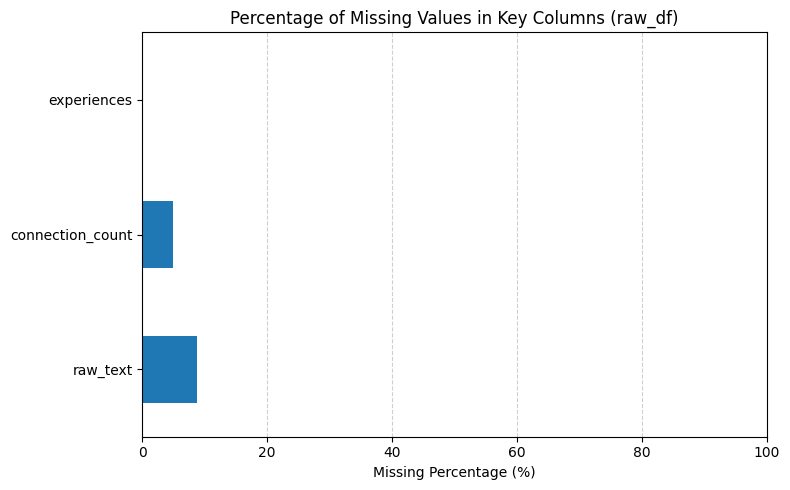


Column Data Types:
Unnamed: 0            int64
profile_id            int64
profile_name         object
profile_url          object
connection_count    float64
experiences          object
raw_text             object
dtype: object


,Unnamed: 0,profile_id,profile_name,profile_url,connection_count,experiences,raw_text
0,0,1,Hamda Shah,https://www.linkedin.com/in/hamda-shah-8a39b532a/,500.0,"[{'title': 'Tutor', 'company': 'Fine Tutors · ...","I am an A level student at Bishopshalt, aspiri..."
1,1,2,Abhishek Saha,https://www.linkedin.com/in/saha-abhishek/,500.0,"[{'title': 'Performance & Data Analyst', 'comp...",With an MSc in Business Analytics from Loughbo...
2,2,3,Tanatswa Muzvidzwa,https://www.linkedin.com/in/tanatswa-muzvidzwa/,351.0,"[{'title': 'University Student', 'company': 'U...",Currently in my 2nd year studying Economics at...
3,3,4,Oliver McCulloch,https://www.linkedin.com/in/oli-mcculloch/,356.0,"[{'title': 'Analyst', 'company': 'University o...",A 1st Year student at the University of Exeter...
4,4,5,Eva Guillem,https://www.linkedin.com/in/eva-guillem-754a92...,9.0,"[{'title': 'Childcare Worker', 'company': 'Pos...",My role at Possibilities was supporting and ca...


In [21]:
### NOW ANALYSIS!... wait no cleaning :(


df=pd.read_csv("raw_df.csv")

### clean connection count properly, before i had an issue where i was accidentally multiplying by 10
def clean_connection_count(val):
    if pd.isna(val):
        return np.nan
    val = str(val).strip().lower().replace(",", "")
    if "500+" in val:
        return 500.0
    match = re.search(r"(\d+)", val)
    return float(match.group(1)) if match else np.nan

df['connection_count'] = df['connection_count'].apply(clean_connection_count)

### treat empty lists in 'experiences' as NaN
df['experiences'] = df['experiences'].apply(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)

### treat empty or whitespace-only raw_text as NaN
df['raw_text'] = df['raw_text'].apply(lambda x: np.nan if not isinstance(x, str) or not x.strip() else x)

### quick missing data viz
relevant_columns = ["connection_count", "experiences", "raw_text"]
missing_percent = (df[relevant_columns].isna().sum() / len(df)) * 100
print(missing_percent)

plt.figure(figsize=(8, 5))
missing_percent.sort_values(ascending=False).plot(kind='barh')
plt.title("Percentage of Missing Values in Key Columns (raw_df)")
plt.xlabel("Missing Percentage (%)")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



#show the data types of each column
print("\nColumn Data Types:")
print(df.dtypes)

df.head()

# **Purging Missingness**

#### **Connection Count & Experiences**
Nature: Most likely MAR (Missing At Random).

Reason: Failures in scraping, lazy-load issues, or profiles with extreme privacy settings.

Reality Check: Almost no active profile has zero experience or hidden connection info unless they’re totally inactive.

Action: Drop these rows — they don't contribute signal and are unlikely to be relevant for outreach.

#### **Raw Text**
Nature: Not MAR — it's informative missingness.

Reason: Person deliberately wrote nothing, which is an implicit signal (low effort, low engagement).

Action: Keep these rows — they may correlate with lower acceptance rates, so this is useful variance.

% of raw_text missing is also likely to fall when we drop rows with nan connection count and experiences as the same scraping failures would affect our raw text


Original rows: 240
Rows after dropping MAR rows: 228
raw_text    4.166667
dtype: float64


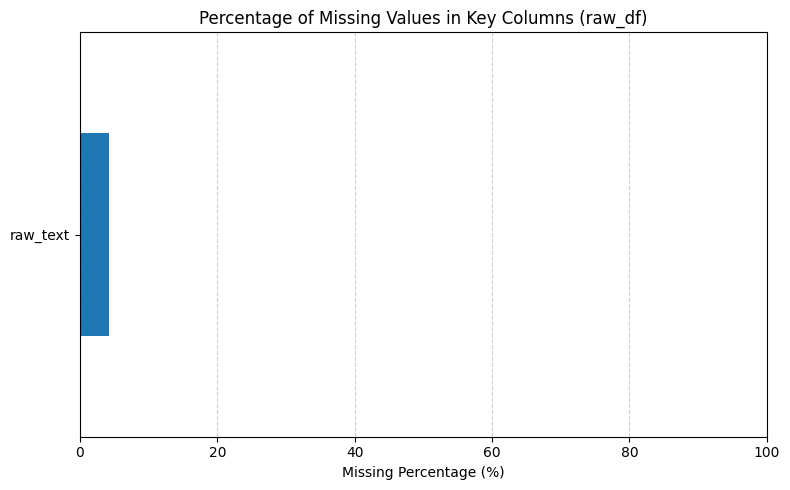

,Unnamed: 0,profile_id,profile_name,profile_url,connection_count,experiences,raw_text
0,0,1,Hamda Shah,https://www.linkedin.com/in/hamda-shah-8a39b532a/,500.0,"[{'title': 'Tutor', 'company': 'Fine Tutors · ...","I am an A level student at Bishopshalt, aspiri..."
1,1,2,Abhishek Saha,https://www.linkedin.com/in/saha-abhishek/,500.0,"[{'title': 'Performance & Data Analyst', 'comp...",With an MSc in Business Analytics from Loughbo...
2,2,3,Tanatswa Muzvidzwa,https://www.linkedin.com/in/tanatswa-muzvidzwa/,351.0,"[{'title': 'University Student', 'company': 'U...",Currently in my 2nd year studying Economics at...
3,3,4,Oliver McCulloch,https://www.linkedin.com/in/oli-mcculloch/,356.0,"[{'title': 'Analyst', 'company': 'University o...",A 1st Year student at the University of Exeter...
4,4,5,Eva Guillem,https://www.linkedin.com/in/eva-guillem-754a92...,9.0,"[{'title': 'Childcare Worker', 'company': 'Pos...",My role at Possibilities was supporting and ca...


In [22]:
# Drop rows missing experiences or connection count
raw_df_clean = df.dropna(subset=["connection_count", "experiences"]).copy()

# raw_text is still allowed to be missing (some users write nothing)
raw_df_clean.reset_index(drop=True, inplace=True)

print(f"Original rows: {len(raw_df)}")
print(f"Rows after dropping MAR rows: {len(raw_df_clean)}")

#quick misisng data vis
relevant_columns = ["raw_text"]
missing_percent = (raw_df_clean[relevant_columns].isna().sum() / len(raw_df)) * 100
print(missing_percent)
plt.figure(figsize=(8, 5))
missing_percent.sort_values(ascending=False).plot(kind='barh')
plt.title("Percentage of Missing Values in Key Columns (raw_df)")
plt.xlabel("Missing Percentage (%)")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#%missing raw_text fell by half when we accounted for scrape failures
raw_df_clean.head()

In [ ]:
# Useful Features? What to analyse

#distributions on connection count, visualise n_experiences, raw-text count, raw_text containing words that match my interests
#first need to do these count features so [{'title': 'Tutor', 'company': 'Fine Tutors exeperiences are structured like a list of dicts, so we just count each dict for n experiences
#save that as a column called n_experiences
#raw text mmm we can just do len? and do len_raw text
#but then we have to do a thing where we set a list of "interest words", and then count how many times that appears in our raw_text for our "same_interest_score"

In [23]:
import ast

#make a fresh working copy so rerunning this cell doesn't break stuff
df_features = raw_df_clean.copy()

#parse experience strings back into proper lists of dicts (if needed)
def safely_parse_list(val):
    if isinstance(val, str):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                return parsed
        except Exception:
            pass
    return []

df_features["experiences"] = df_features["experiences"].apply(safely_parse_list)

#count how many experience items they got
def count_experience_items(val):
    return len(val) if isinstance(val, list) else 0

df_features["n_experiences"] = df_features["experiences"].apply(count_experience_items)

#how many words in their raw_text section? proxy for detail
df_features["len_raw_text"] = df_features["raw_text"].apply(
    lambda x: len(x.split()) if isinstance(x, str) else 0
)

#stuff we care about... signal interest similarity
interest_keywords = [
    "data", "ai", "ml", "machine learning", "python", "analytics", "data science", "data-science", "economics",
    "statistics", "risk", "finance", "markets", "development economics", "development-economics",
    "renewables", "modelling", "modeling", "sql", "energy", "commodities", "game theory", "game-theory", "artificial intelligence"
]

#count how many of our keywords show up
def count_interest_keywords(text):
    if not isinstance(text, str):
        return 0
    text_lower = text.lower()
    return sum(kw in text_lower for kw in interest_keywords)

df_features["same_interest_score"] = df_features["raw_text"].apply(count_interest_keywords)

#check if they went to exeter (either in their text or experience list)
def mark_same_uni(experiences, raw_text, keyword="exeter"):
    keyword = keyword.lower()
    in_text = isinstance(raw_text, str) and keyword in raw_text.lower()
    in_experiences = any(
        isinstance(exp, dict) and any(
            isinstance(v, str) and keyword in v.lower()
            for v in exp.values()
        )
        for exp in experiences if isinstance(experiences, list)
    )
    return int(in_text or in_experiences)

df_features["same_uni"] = df_features.apply(
    lambda row: mark_same_uni(row["experiences"], row["raw_text"]),
    axis=1
)

#print and preview one just to sanity check
print(df_features["experiences"].iloc[0])
df_features.head()


[{'title': 'Tutor', 'company': 'Fine Tutors · Part-time', 'date_range': 'Dec 2024 - Present · 5 mos', 'location': 'Northolt, England, United Kingdom · On-site'}, {'title': 'Project Manager', 'company': 'HS2 (High Speed Two) Ltd · Temporary', 'date_range': 'Mar 2024 - Mar 2024 · 1 mo', 'location': 'North Acton · On-site'}, {'title': 'Sales Attendant', 'company': 'Excel London · Temporary', 'date_range': 'Jan 2024 - Jan 2024 · 1 mo', 'location': 'Illford · On-site'}, {'title': 'Exhibitor', 'company': 'Excel London · Temporary', 'date_range': 'Sep 2023 - Sep 2023 · 1 mo', 'location': None}, {'title': 'Careers in Personal Finance with the Personal Finance Society', 'company': 'Springpod', 'date_range': 'Issued Dec 2024 · Expired Dec 2024', 'location': None}]


,Unnamed: 0,profile_id,profile_name,profile_url,connection_count,experiences,raw_text,n_experiences,len_raw_text,same_interest_score,same_uni
0,0,1,Hamda Shah,https://www.linkedin.com/in/hamda-shah-8a39b532a/,500.0,"[{'title': 'Tutor', 'company': 'Fine Tutors · ...","I am an A level student at Bishopshalt, aspiri...",5,280,5,0
1,1,2,Abhishek Saha,https://www.linkedin.com/in/saha-abhishek/,500.0,"[{'title': 'Performance & Data Analyst', 'comp...",With an MSc in Business Analytics from Loughbo...,12,2108,11,0
2,2,3,Tanatswa Muzvidzwa,https://www.linkedin.com/in/tanatswa-muzvidzwa/,351.0,"[{'title': 'University Student', 'company': 'U...",Currently in my 2nd year studying Economics at...,6,202,3,1
3,3,4,Oliver McCulloch,https://www.linkedin.com/in/oli-mcculloch/,356.0,"[{'title': 'Analyst', 'company': 'University o...",A 1st Year student at the University of Exeter...,8,1423,5,1
4,4,5,Eva Guillem,https://www.linkedin.com/in/eva-guillem-754a92...,9.0,"[{'title': 'Childcare Worker', 'company': 'Pos...",My role at Possibilities was supporting and ca...,2,91,1,0



--- Summary Stats: connection_count ---
count    228.000000
mean     309.986842
std      180.247908
min        2.000000
25%      133.500000
50%      342.000000
75%      500.000000
max      500.000000
Name: connection_count, dtype: float64

--- Summary Stats: n_experiences ---
count    228.000000
mean       6.333333
std        3.159955
min        0.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       18.000000
Name: n_experiences, dtype: float64

--- Summary Stats: len_raw_text ---
count     228.000000
mean      472.964912
std       505.590350
min         0.000000
25%        96.000000
50%       318.000000
75%       633.500000
max      2878.000000
Name: len_raw_text, dtype: float64

--- Summary Stats: same_interest_score ---
count    228.000000
mean       3.135965
std        2.315229
min        0.000000
25%        1.000000
50%        3.000000
75%        4.250000
max       11.000000
Name: same_interest_score, dtype: float64


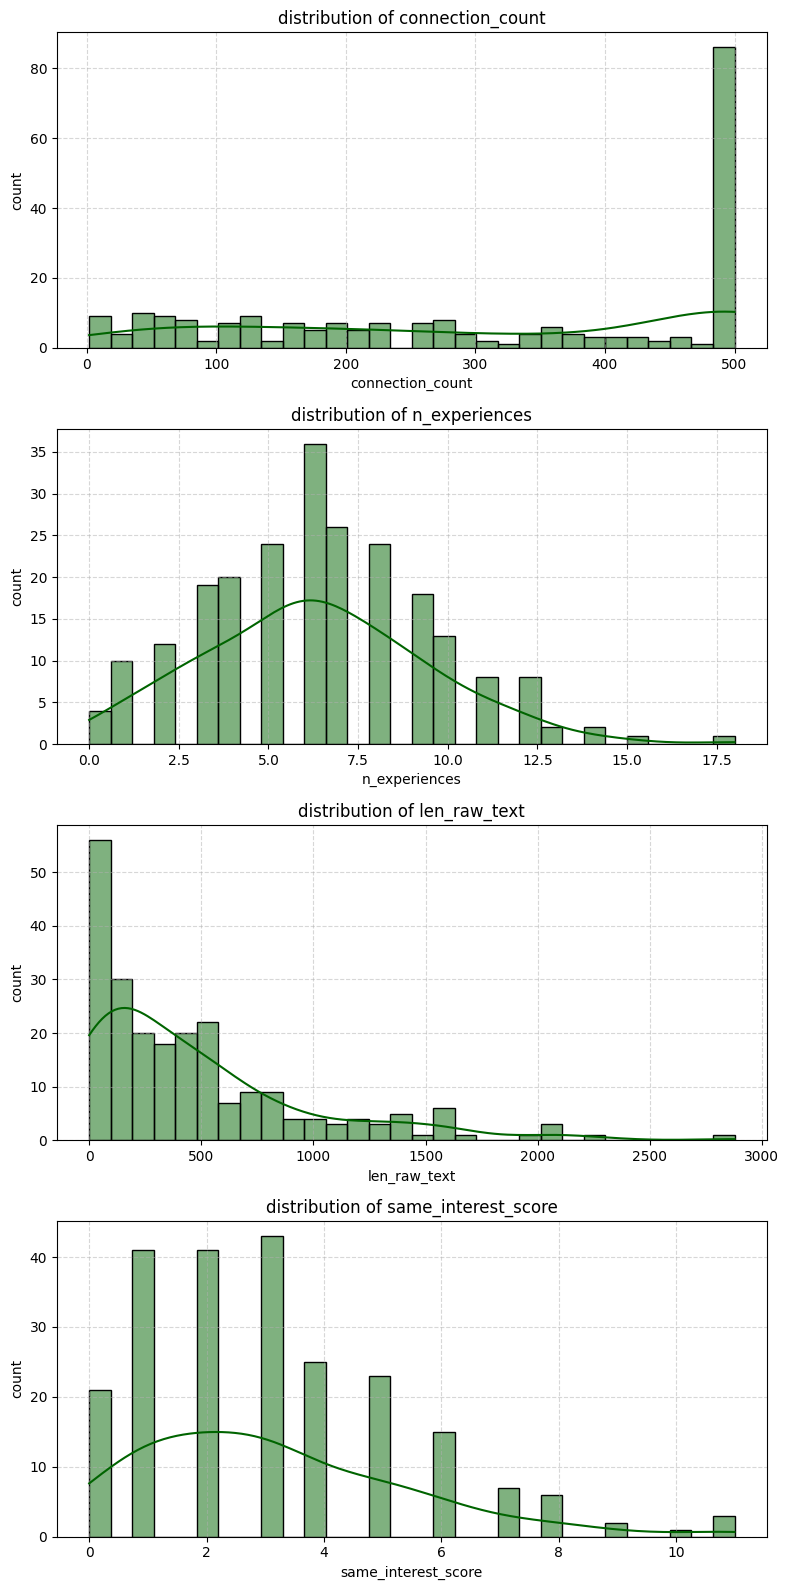

In [11]:


#what we're plotting
numeric_cols = ["connection_count", "n_experiences", "len_raw_text", "same_interest_score"]

#print summary stats
for col in numeric_cols:
    print(f"\n--- Summary Stats: {col} ---")
    print(df_features[col].describe())

#plot hists for each numeric col
fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(8, 4 * len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_features, x=col, bins=30, kde=True, ax=axes[i], color="darkgreen")
    axes[i].set_title(f"distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("count")
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### **distribution insights – cleaned profile data**

the following summary statistics and histograms describe the key numeric features extracted from linkedin profiles in our cleaned dataset (`df_features`).

---

### **connection_count**

- **median**: 342  
- **mean**: ~310  
- **min**: 2  
- **max**: 500  
- **observation**: right-skewed distribution with a spike at 500, reflecting linkedin’s "500+" cap  
- **interpretation**: most users cluster high, but a tail exists — perfect for testing **hypothesis 1** (low-connection coordination game) and **hypothesis 2** (500-status push)

---

### **n_experiences**

- **median**: 6  
- **mean**: ~6.33  
- **min**: 0  
- **max**: 18  
- **observation**: centered distribution with a wide but realistic spread  
- **interpretation**: reflects how "busy" a profile is — work/education/certs. could correlate with general engagement

---

### **len_raw_text**

- **median**: 318  
- **mean**: ~473  
- **min**: 0  
- **max**: 2878  
- **observation**: fat right tail — some users write essays  
- **interpretation**: used as a proxy for profile effort, supports **hypothesis 4** (detail = intent to connect)

---

### **same_interest_score**

- **median**: 3  
- **mean**: ~3.27  
- **min**: 0  
- **max**: 12  
- **observation**: most fall between 1–5 hits, a few score high  
- **interpretation**: measures alignment with **my interests** — fuels **hypothesis 3** that similarity breeds acceptance


### **Feature Engineering Decision — Categorical Binning**

Given the modest sample size of our dataset (~200–300 observations), we opt to convert key numeric features into categorical bins rather than using continuous values. This decision is motivated by the need for model robustness, interpretability, and performance — especially in early logistic regression and rule-based models. Hard tags help reduce noise, avoid overfitting, and make it easier to identify patterns aligned with our hypotheses. Each bin is intentionally defined based on logical cutoffs (e.g., 500+ connections, long text profiles, shared interests), allowing us to track profile archetypes and their corresponding likelihood of connection acceptance.


In [24]:
#make a copy before tagging
df_tagged = df_features.copy()

###hypothesis 1: coordination game — low connection count (<=50)
df_tagged["tag_h1_coordination_game"] = df_tagged["connection_count"].apply(lambda x: 1 if x <= 50 else 0)

###hypothesis 2: status seekers — near-threshold (400–499)
df_tagged["tag_h2_status_seekers"] = df_tagged["connection_count"].apply(lambda x: 1 if 400 <= x < 500 else 0)

###hypothesis 3: interest alignment — high interest score (>=5)
df_tagged["tag_h3_shared_interests"] = df_tagged["same_interest_score"].apply(lambda x: 1 if x >= 5 else 0)

###hypothesis 4: profile effort — detailed profile (len_raw_text > 600)
df_tagged["tag_h4_profile_effort"] = df_tagged["len_raw_text"].apply(lambda x: 1 if x > 600 else 0)

###bonus: shared university, controlling for this later
df_tagged["tag_same_uni"] = df_tagged["same_uni"]  # already binary

###new idea gender, whose kinder to me men or women?
import gender_guesser.detector as gender
#initialize the gender detector
gd = gender.Detector(case_sensitive=False)  #case-insensitive for better matching

#function to predict if likely female
def is_likely_female(name):
    prediction = gd.get_gender(name)

    #optional uncomment to debug predictions
    #print(f"Name: {name}, Prediction: {prediction}")

    if prediction in ['female', 'mostly_female']:
        return 1
    elif prediction in ['male', 'mostly_male', 'andy', 'unknown']:
        return 0
    return 0


#extract first names
df_tagged['first_name'] = df_tagged['profile_name'].str.split().str[0]  # Takes the first word
df_tagged['tag_h5_likely_female'] = df_tagged['first_name'].apply(is_likely_female)


#columns to keep
cols_to_keep = [
    "profile_id", "profile_name", "profile_url",
    "tag_h1_coordination_game",
    "tag_h2_status_seekers",
    "tag_h3_shared_interests",
    "tag_h4_profile_effort",
    "tag_same_uni",
    'tag_h5_likely_female'
]

#reduce to just relevant columns
df_tagged = df_tagged[cols_to_keep].copy()

# keep only rows where same uni tag is marked as 1
df_tagged = df_tagged[df_tagged["tag_same_uni"] == 1].copy()
#now we can drop it
# drop the column now that filtering is done
df_tagged = df_tagged.drop(columns=["tag_same_uni"])
# add tracking columns
df_tagged["connection_sent"] = 0
df_tagged["connection_accepted"] = 0

df_tagged.head(50)



,profile_id,profile_name,profile_url,tag_h1_coordination_game,tag_h2_status_seekers,tag_h3_shared_interests,tag_h4_profile_effort,tag_h5_likely_female,connection_sent,connection_accepted
2,3,Tanatswa Muzvidzwa,https://www.linkedin.com/in/tanatswa-muzvidzwa/,0,0,0,0,0,0,0
3,4,Oliver McCulloch,https://www.linkedin.com/in/oli-mcculloch/,0,0,1,1,0,0,0
6,7,Nicole C.,https://www.linkedin.com/in/nicole-c-0887561b9/,0,0,0,0,1,0,0
8,9,Nehir Yurtsever,https://www.linkedin.com/in/nehir-yurtsever-29...,0,0,1,0,1,0,0
9,10,Aleem Abbas-Hussain,https://www.linkedin.com/in/aleem-abbas-hussain/,0,0,0,0,0,0,0
10,11,Mohammed Alnofal,https://www.linkedin.com/in/mohammed-alnofal-7...,0,0,1,1,0,0,0
11,12,Dayoon Jeong,https://www.linkedin.com/in/dayoon-jeong-29854...,0,0,0,0,0,0,0
12,13,Thomas Reece,https://www.linkedin.com/in/thomas-reece-78b32...,0,0,0,0,0,0,0
13,14,Heeya Peshwani,https://www.linkedin.com/in/heeya-peshwani/,0,0,0,0,0,0,0
14,15,Finlay Douglas,https://www.linkedin.com/in/finlay-douglas-042...,0,0,0,0,0,0,0


# **DF_TAGGED TO SQL TABLE**

In [25]:
# Connect to the SQLite database
#conn = sqlite3.connect("linkedin_profiles.db")
#df_tagged.to_sql("train_test_data", conn, if_exists="replace", index=False)
#conn.close()



# **AUTO-MATED OUTREACH**

In [34]:
def linkedin_outreach(
    db_path="linkedin_profiles.db",
    batch_size_range=(5, 10),
    break_duration_range=(45, 90),
    max_invites=30,
    driver=None,
    load_driver_func=None,
    keep_driver_open=True
):
    import sqlite3, random, time
    import pandas as pd
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC

    # Load driver if not provided
    if driver is None:
        if load_driver_func is None:
            raise ValueError("Must provide a driver or load_driver_func")
        driver = load_driver_func()

    try:
        conn = sqlite3.connect(db_path)
        df = pd.read_sql_query(
            "SELECT profile_url FROM train_test_data WHERE connection_sent IS NULL OR connection_sent = 0 ORDER BY profile_id ASC",
            conn
        )
        conn.close()

        if max_invites is not None:
            df = df.head(max_invites)
            print(f"Limiting outreach to {max_invites} invites.")

        pause_after_n = random.randint(*batch_size_range)
        processed_count = 0
        total_sent = 0

        CONNECT_BUTTON_SELECTOR = "button[aria-label*='Invite'][aria-label*='to connect']"
        SEND_WITHOUT_MESSAGE_SELECTOR = "button[aria-label='Send without a note']"

        for _, row in df.iterrows():
            if max_invites is not None and total_sent >= max_invites:
                break

            url = row["profile_url"]
            print(f"Visiting: {url}")

            try:
                driver.execute_script("window.open(arguments[0]);", url)
                driver.switch_to.window(driver.window_handles[-1])

                human_sleep(4, 2)
                human_scroll(driver, total_scrolls=random.randint(3, 6))
                random_hover(driver, "section")

                wait = WebDriverWait(driver, 10)
                connect_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, CONNECT_BUTTON_SELECTOR)))

                button_text = connect_button.text.strip().lower()
                if "pending" in button_text or "withdraw" in button_text:
                    print(f"Already connected or request pending for {url}. Skipping.")
                    driver.close()
                    driver.switch_to.window(driver.window_handles[0])
                    continue

                driver.execute_script("arguments[0].scrollIntoView(true);", connect_button)
                time.sleep(0.5)
                driver.execute_script("arguments[0].click();", connect_button)
                print(f"Clicked 'Connect' for {url}")

                try:
                    send_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, SEND_WITHOUT_MESSAGE_SELECTOR)))
                    driver.execute_script("arguments[0].click();", send_button)
                    print(f"Sent without a note for {url}")
                except:
                    print(f"Connection sent directly for {url}")

                # Write immediately to DB
                try:
                    conn = sqlite3.connect(db_path)
                    cursor = conn.cursor()
                    cursor.execute(
                        "UPDATE train_test_data SET connection_sent = 1 WHERE profile_url = ?",
                        (url,)
                    )
                    conn.commit()
                    conn.close()
                    print(f"DB updated for {url}")
                except Exception as e:
                    print(f"DB write failed for {url}: {e}")

                total_sent += 1

            except Exception as e:
                print(f"Error at {url}: {e}")

            finally:
                driver.close()
                driver.switch_to.window(driver.window_handles[0])
                human_sleep(3, 1)
                processed_count += 1

                if random.random() < 0.4:
                    take_linkedin_detour(driver)
                    human_sleep(base=5, variance=2)
                    human_scroll(driver)
                    random_hover(driver, "a")

                if processed_count >= pause_after_n:
                    long_break = random.uniform(*break_duration_range)
                    print(f"\n--- Long break: {long_break:.1f} seconds ---\n")
                    time.sleep(long_break)
                    processed_count = 0
                    pause_after_n = random.randint(*batch_size_range)

        print(f"Total invites sent: {total_sent}")

    finally:
        if not keep_driver_open:
            driver.quit()
            print("Outreach complete! Driver closed.")
        else:
            print("Outreach complete! Driver remains open.")


linkedin_outreach(load_driver_func=load_linkedin_session, max_invites=20, keep_driver_open=True)

Logged in with saved session cookies.
Limiting outreach to 20 invites.
Visiting: https://www.linkedin.com/in/tanatswa-muzvidzwa/
Clicked 'Connect' for https://www.linkedin.com/in/tanatswa-muzvidzwa/
Sent without a note for https://www.linkedin.com/in/tanatswa-muzvidzwa/
DB updated for https://www.linkedin.com/in/tanatswa-muzvidzwa/

[Detour] Visiting My Network page...
Visiting: https://www.linkedin.com/in/oli-mcculloch/
Error at https://www.linkedin.com/in/oli-mcculloch/: Message: 

Visiting: https://www.linkedin.com/in/nicole-c-0887561b9/
Clicked 'Connect' for https://www.linkedin.com/in/nicole-c-0887561b9/
Sent without a note for https://www.linkedin.com/in/nicole-c-0887561b9/
DB updated for https://www.linkedin.com/in/nicole-c-0887561b9/
Visiting: https://www.linkedin.com/in/nehir-yurtsever-2932a0233/
Clicked 'Connect' for https://www.linkedin.com/in/nehir-yurtsever-2932a0233/
Sent without a note for https://www.linkedin.com/in/nehir-yurtsever-2932a0233/
DB updated for https://www.

# **THE FULL PIPELINE**

Scrape Profile Previews (People You May Know)

Save Full Profile HTML

Parse HTML → Build raw_df

Clean and Feature Engineer → df_features

Hypothesis-Based Tagging → df_tagged

Filter / Prioritize / Export

Automate Outreach & Tracking